# Dhh1p analysis

In [45]:
%reset -f
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
from scipy.stats import pearsonr, spearmanr, ttest_ind
import seaborn as sns; sns.set(style="white", color_codes=True)
import matplotlib.pyplot as plt
import csv

sns.set(style="ticks", color_codes=True,font_scale=2)
snsRed, snsBlue, snsGreen = sns.color_palette("Set1", n_colors=8, desat=.5)[0:3]

## 1. Load files

In [46]:
folder = "/seq/schatz/hfang/Projects/RiboSeq/Radhakrishnan_2016/new_te_analysis"

wt_rep1 = folder + "/SRR3493886/genesTE.csv"
wt_rep2 = folder + "/SRR3493887/genesTE.csv"
codon_wt_rep1 = folder + "/SRR3493886/codons.csv"
codon_wt_rep2 = folder + "/SRR3493887/codons.csv"
Dhh1KO_rep1 = folder + "/SRR3493890/genesTE.csv"
Dhh1KO_rep2 = folder + "/SRR3493891/genesTE.csv"
codon_Dhh1KO_rep1 = folder + "/SRR3493890/codons.csv"
codon_Dhh1KO_rep2 = folder + "/SRR3493891/codons.csv"
Dhh1OE_rep1 = folder + "/SRR3493894/genesTE.csv"
Dhh1OE_rep2 = folder + "/SRR3493895/genesTE.csv"
codon_Dhh1OE_rep1 = folder + "/SRR3493894/codons.csv"
codon_Dhh1OE_rep2 = folder + "/SRR3493895/codons.csv"

original_fn = "/seq/schatz/hfang/Projects/RiboSeq/Radhakrishnan_2016/original_analysis/GSE81269_RPKM-All-Datasets.txt"
codon_weinberg = "../Data/skr_weinberg_codons.csv"
gene_tAI ="../Data/SacCer_stAIcalc_Sabi_Tuller.txt"
codon_stAI ="../Data/Yeast_codon_stAI.csv"
codon_tAI ="../Data/tAI.csv"

In [47]:
deltaTE_cutoff = 1

In [48]:
filesToLoad = [wt_rep1, wt_rep2, codon_wt_rep1, codon_wt_rep2, 
               Dhh1KO_rep1, Dhh1KO_rep2, codon_Dhh1KO_rep1, codon_Dhh1KO_rep2, 
               Dhh1OE_rep1, Dhh1OE_rep2, codon_Dhh1OE_rep1, codon_Dhh1OE_rep2,
               gene_tAI, codon_tAI, codon_weinberg]
df_dic = {}
for f in filesToLoad:
    tmp_df = pd.read_table(f, header=0)
    df_dic[f] = tmp_df

df_dic[codon_stAI] = pd.read_table(codon_stAI, header=0, sep=",")

In [49]:
TePair = {"TE_WT":[wt_rep1, wt_rep2],
          "TE_KO":[Dhh1KO_rep1, Dhh1KO_rep2], 
          "TE_OE":[Dhh1OE_rep1, Dhh1OE_rep2]}
CodonPair = {"codon_WT":[codon_wt_rep1, codon_wt_rep2], 
             "codon_KO":[codon_Dhh1KO_rep1, codon_Dhh1KO_rep2],
             "codon_OE":[codon_Dhh1OE_rep1, codon_Dhh1OE_rep2]}

for k,v in TePair.items():
    df_dic[k] = pd.merge(df_dic[v[0]], df_dic[v[1]], on="gene", suffixes=["_rep1","_rep2"])
    
for k,v in CodonPair.items():
    df_dic[k] = pd.merge(df_dic[v[0]], df_dic[v[1]], on="codon", suffixes=["_rep1","_rep2"])

## 1. TE correlation between replicates

In [50]:
samples = ["WT", "KO", "OE"]

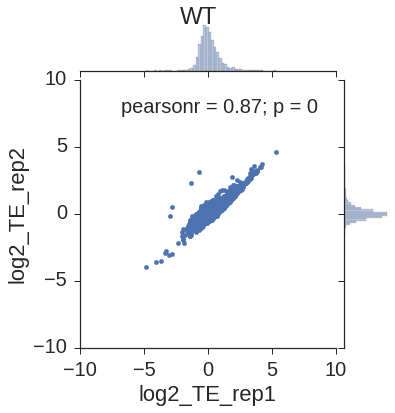

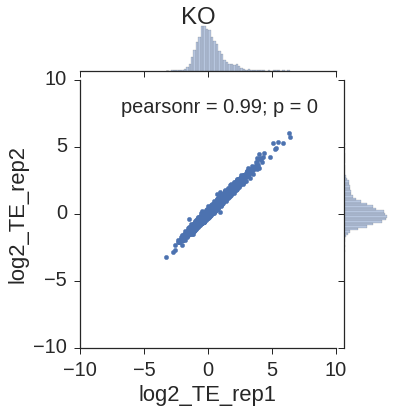

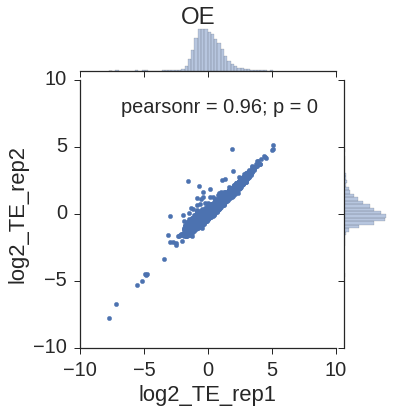

In [51]:
for sample in samples:
    plt.clf()
    f1 = sns.jointplot(x="log2_TE_rep1", y="log2_TE_rep2",  
                       data=df_dic["TE_" + sample],
                       xlim=[-10,10], ylim=[-10,10])
    f1.fig.suptitle(sample)
    plt.gcf()
    plt.savefig("../Figures/Radhakrishnan/SKR_" + sample +"_TE_corr.pdf")
    plt.show()
# WT -> 0.96 if filter by tpm>10

## 2. codon elongation rate correlation between replicates

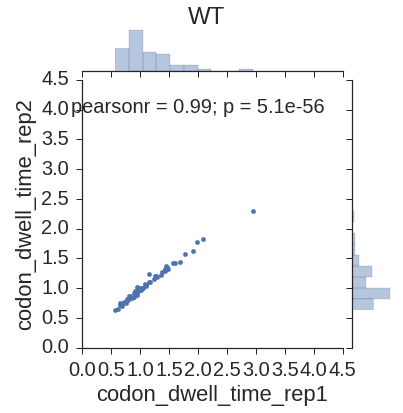

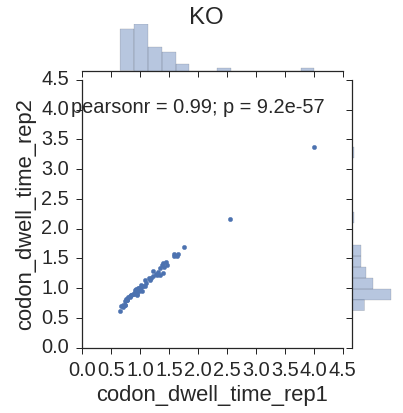

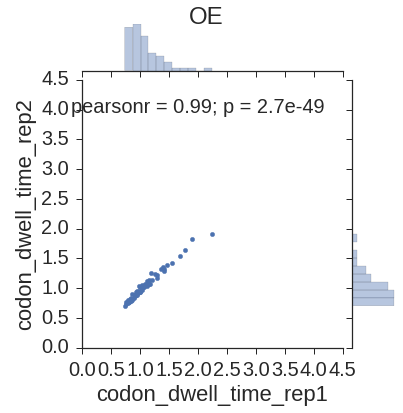

In [52]:
for sample in samples:
    plt.clf()
    f1 = sns.jointplot(x="codon_dwell_time_rep1", y="codon_dwell_time_rep2",  
                       data=df_dic["codon_" + sample],
                       xlim=[0, 4.5], ylim=[0, 4.5])
    f1.fig.suptitle(sample)
    plt.gcf()
    plt.savefig("../Figures/Radhakrishnan/SKR_" + sample +"_codon_corr.pdf")
    plt.show()

## 3. Compare TE between conditions

### 0) Getting rpkm values from original paper.

In [53]:
original = pd.read_table(original_fn, header=0)
original = pd.merge(original, df_dic[gene_tAI], left_on='Gene', right_on="genes_id")

original_map = {"WT_RNA_rep1":"IRWT", "WT_RNA_rep2":"RRWT",
                "WT_Ribo_rep1":"IPWT", "WT_Ribo_rep2":"RPWT",
                "KO_RNA_rep1":"IRDhKO", "KO_RNA_rep2":"RRDhKO",
                "KO_Ribo_rep1":"IPDhKO", "KO_Ribo_rep2":"RPDhKO",
                "OE_RNA_rep1":"IRDhOE", "OE_RNA_rep2":"RRDhOE",
                "OE_Ribo_rep1":"IPDhOE", "OE_Ribo_rep2":"RPDhOE"}
                                                      
for tpm, rpkm in original_map.items():
    original[tpm] = original[rpkm] * 1000000 / np.sum(original[rpkm])

for tpm in original_map.keys():
    original = original[original[tpm] > 0]
print(original.shape)


(5485, 34)


In [54]:
lst = ["WT_RNA", "WT_Ribo", "KO_RNA", "KO_Ribo", "OE_RNA", "OE_Ribo"]

for i in lst:
    original[i] = 1/2 * (original[i + "_rep1"] + original[i + "_rep2"])

original_Ribo_RNA_pairs = {"log2_TE_WT":["IRWT", ("IPWT", "RPWT")],
                           "log2_TE_OE":["IRDhOE", ("IPDhOE", "RPDhOE")],
                           "log2_TE_KO":["RRDhKO", ("IPDhKO", "RPDhKO")],
                          }

for k,v in original_Ribo_RNA_pairs.items():
    original[k + "_rep1"] = np.log2(original[v[1][0]] / original[v[0]])
    original[k + "_rep2"] = np.log2(original[v[1][1]] / original[v[0]])

for k,v in original_Ribo_RNA_pairs.items():
    original[k] = 1/2 * (original[k + "_rep1"] + original[k + "_rep2"])

### 1) Compare scikit-ribo & rpkm estimates

In [55]:
comparisons = [("KO", "WT"), ("OE", "WT"), ("OE", "KO")] 
prefixes = ["skr_", "rpkm_"]

In [56]:
# mean of replicates
for prefix in prefixes:
    for comparison in comparisons:
        l, r = comparison
        if prefix == "skr_":
            tmp = pd.merge(df_dic["TE_" + l], df_dic["TE_" + r], 
                           on='gene', suffixes=["_" + l, "_" + r])
            tmp = pd.merge(tmp, df_dic[gene_tAI], 
                           left_on='gene', right_on="genes_id")
            tmp["log2_TE_" + l] = (tmp["log2_TE_rep1_" + l] + 
                                   tmp["log2_TE_rep2_" + l]) / 2
            tmp["log2_TE_" + r] = (tmp["log2_TE_rep1_" + r] + 
                                   tmp["log2_TE_rep2_" + r]) / 2
            tmp["deltaTE"] = tmp["log2_TE_" + l] - tmp["log2_TE_" + r]
            df_dic[prefix + l + "_VS_" + r] = tmp
        elif prefix == "rpkm_":
            tmp = original[["Gene", "log2_TE_" + l, "log2_TE_" + r, "stAI"]]
            tmp.rename(columns={"Gene": "gene"}, inplace=True)
            tmp["deltaTE"] = tmp["log2_TE_" + l] - tmp["log2_TE_" + r]
            df_dic[prefix + l + "_VS_" + r] = tmp

/sonas-hs/lyon/hpc/home/hfang/miniconda3/lib/python3.4/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/sonas-hs/lyon/hpc/home/hfang/miniconda3/lib/python3.4/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


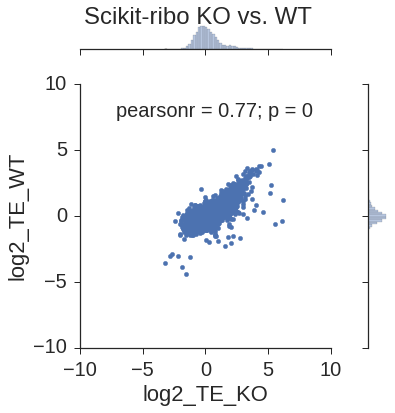

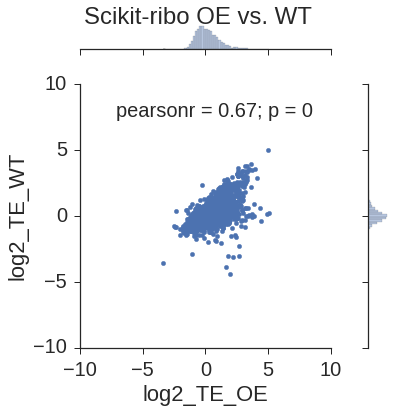

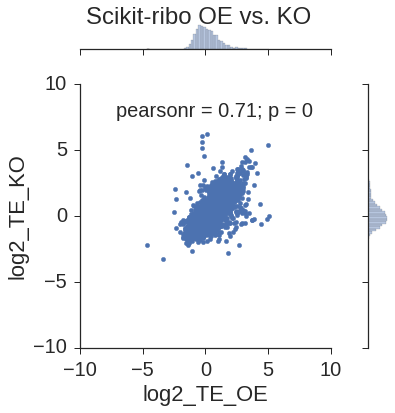

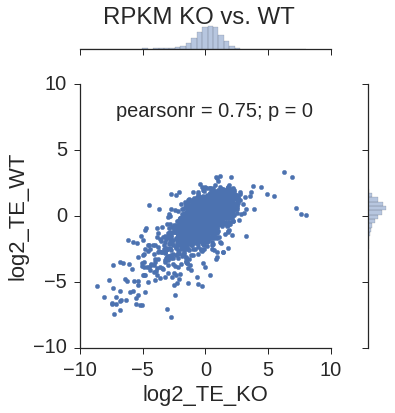

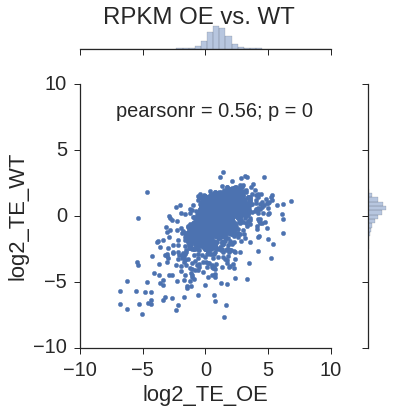

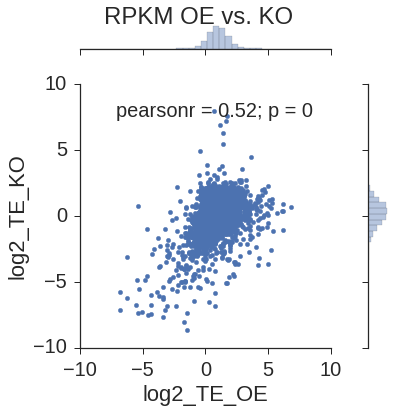

In [57]:
# plot TE correlation
for prefix in prefixes:
    for comparison in comparisons:
        l, r = comparison
        data_prefix = prefix + l + "_VS_" + r
        plt.clf()
        S1 = sns.jointplot(x="log2_TE_" + l, y="log2_TE_" + r, 
                           data=df_dic[data_prefix],  
                           xlim= [-10,10], ylim= [-10,10])
        tool = "Scikit-ribo " if prefix == "skr_" else "RPKM "
        S1.fig.suptitle(tool + l + " vs. " + r)
        plt.tight_layout(); plt.gcf()
        plt.savefig("../Figures/Radhakrishnan/" + data_prefix + "_TE_corr.pdf")
        plt.show()

Number of genes: 3440
Number of tail genes:  50 50
('skr_', ('KO', 'WT'))
Upper & lower bound -0.93685 1.7104


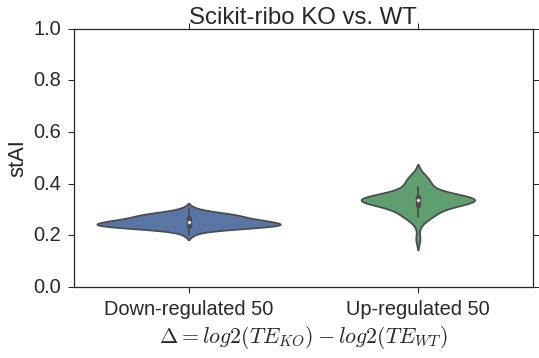

Number of genes: 3529
Number of tail genes:  50 50
('skr_', ('OE', 'WT'))
Upper & lower bound -0.80465 2.13255


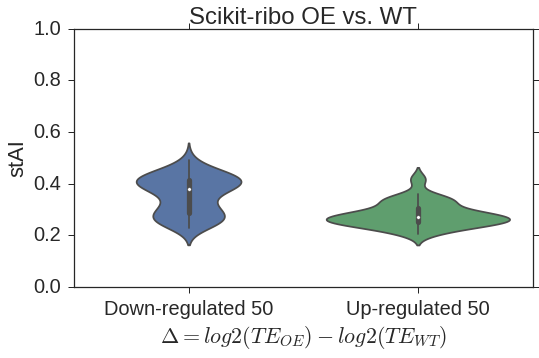

Number of genes: 3587
Number of tail genes:  50 50
('skr_', ('OE', 'KO'))
Upper & lower bound -1.6146 1.74695


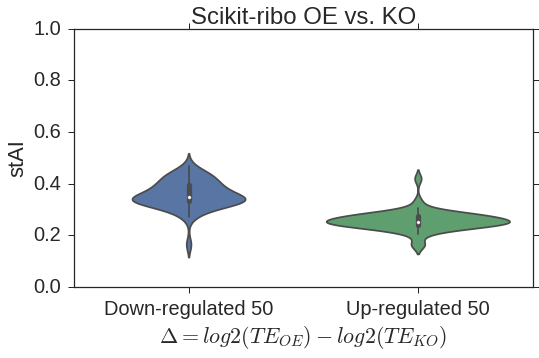

Number of genes: 3495
Number of tail genes:  50 50
('rpkm_', ('KO', 'WT'))
Upper & lower bound -1.48293398172 1.62899534736


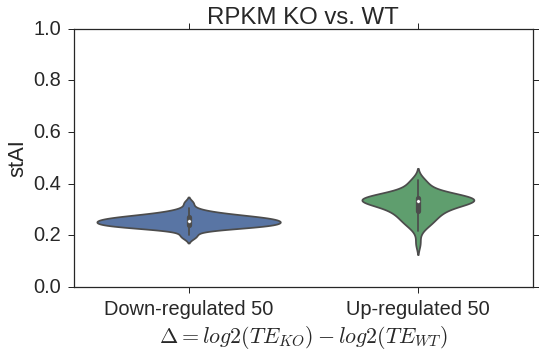

Number of genes: 3590
Number of tail genes:  50 50
('rpkm_', ('OE', 'WT'))
Upper & lower bound -1.05148896105 2.43109643166


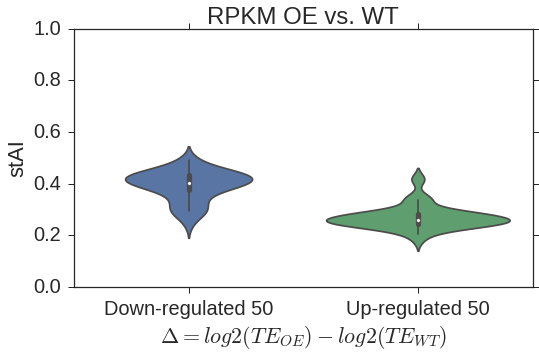

Number of genes: 3644
Number of tail genes:  50 50
('rpkm_', ('OE', 'KO'))
Upper & lower bound -1.74670089773 2.70190236703


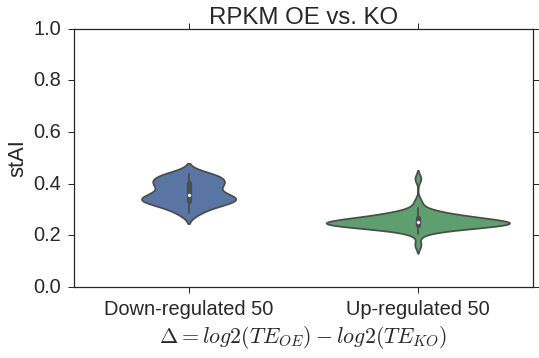

In [70]:
# tail genes comparison
tails_dic = {}
down_tail, up_tail = 50, 50
for prefix in prefixes:
    for comparison in comparisons:
        l, r = comparison
        data_prefix = prefix + l + "_VS_" + r
        tmp = df_dic[data_prefix].copy()
        tmp = pd.merge(tmp, original, left_on="gene", right_on="Gene")
        tmp = tmp[(tmp[l + "_RNA"] > 10) & (tmp[r + "_RNA"] > 10) & 
                  (tmp[l + "_Ribo"] > 10) & (tmp[r + "_Ribo"] > 10)]
        print("Number of genes: " + str(tmp.shape[0]))
        # tail genes
        # down_tail, up_tail = int(tmp.shape[0] * 0.01), int(tmp.shape[0] * 0.02)
        print("Number of tail genes: ", down_tail, up_tail)
        tmp_down_tail = tmp.sort_values("deltaTE").head(down_tail)
        tmp_up_tail   = tmp.sort_values("deltaTE", ascending=False).head(up_tail)
        print(((prefix, comparison)))
        tails_dic[(prefix, comparison)] = [tmp_down_tail, tmp_up_tail]
        print("Upper & lower bound", 
              tmp_down_tail.tail(1)["deltaTE"].values[0], 
              tmp_up_tail.tail(1)["deltaTE"].values[0])
        tmp_down_tail[["gene"]].to_csv(path_or_buf="../Data/Radhakrishnan/" + data_prefix + "_down_50.csv", 
                                       sep='\t', header=True, index=False, quoting=csv.QUOTE_NONE) 
        tmp_up_tail[["gene"]].to_csv(path_or_buf="../Data/Radhakrishnan/" + data_prefix + "_up_50.csv", 
                                     sep='\t', header=True, index=False, quoting=csv.QUOTE_NONE) 
        # violin stAI in two classes
        tmp_down_tail["class"] = "Down-regulated 50"
        tmp_up_tail["class"] = "Up-regulated 50"
        tmp_tail_combine = pd.concat([tmp_down_tail, tmp_up_tail])
        plt.clf()
        S2 = sns.violinplot(x="class", y="stAI_x", data=tmp_tail_combine)
        plt.ylabel('stAI') 
        tool = "Scikit-ribo " if prefix == "skr_" else "RPKM "
        plt.title(tool + l + " vs. " + r) 
        plt.xlabel("$\Delta = log2(TE_{" + l + "}) - log2(TE_{" + r + "})$")
        plt.ylim(0, 1); plt.tight_layout(); plt.gcf()
        plt.savefig("../Figures/Radhakrishnan/" + data_prefix + "_tail50_genes_stAI.pdf")
        plt.show()

KO VS WT
15 13


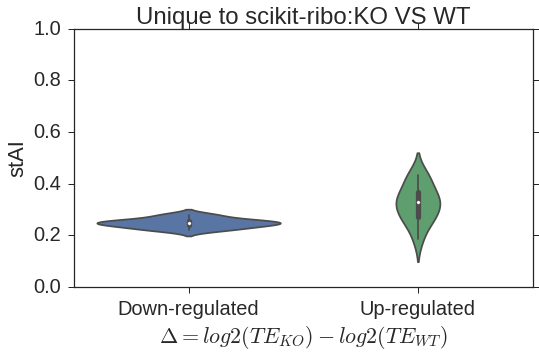

OE VS WT
21 13


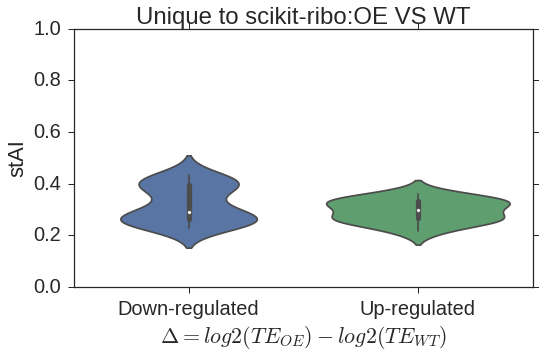

OE VS KO
16 11


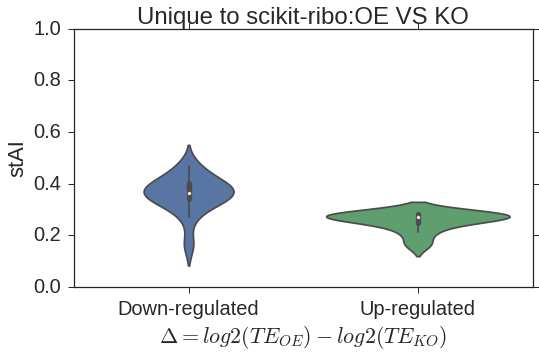

In [73]:
for comparison in comparisons:
    l, r = comparison
    skr_down = set(tails_dic[("skr_", comparison)][0]["gene"])
    rpkm_down = set(tails_dic[("rpkm_", comparison)][0]["gene"])
    skr_up = set(tails_dic[("skr_", comparison)][1]["gene"])
    rpkm_up = set(tails_dic[("rpkm_", comparison)][1]["gene"])
    uniq_down = pd.DataFrame([i for i in skr_down if i not in rpkm_down], columns=["gene"])
    uniq_down = pd.merge(uniq_down, original, left_on='gene', right_on="genes_id")
    uniq_down["class"] = "down"
    uniq_up = pd.DataFrame([i for i in skr_up if i not in rpkm_up], columns=["gene"])
    uniq_up = pd.merge(uniq_up, original, left_on='gene', right_on="genes_id")
    uniq_up["class"] = "up"
    print( l + " VS " + r )
    print(len(uniq_down), len(uniq_up))
    uniqs = pd.concat([uniq_down, uniq_up])
    # plot
    plt.clf()
    S2 = sns.violinplot(x="class", y="stAI", data=uniqs)
    plt.ylabel('stAI') 
    S2.set_xticklabels(["Down-regulated", "Up-regulated"])
    plt.title( "Unique to scikit-ribo:" +  l + " VS " + r ) 
    plt.xlabel("$\Delta = log2(TE_{" + l + "}) - log2(TE_{" + r + "})$")
    plt.ylim(0, 1) 
    plt.tight_layout(); plt.gcf()
    plt.savefig("../Figures/Radhakrishnan/" + l + "_VS_" + r + "_unique_skr_genes_stAI.pdf")
    plt.show()

(143, 11) (288, 11)


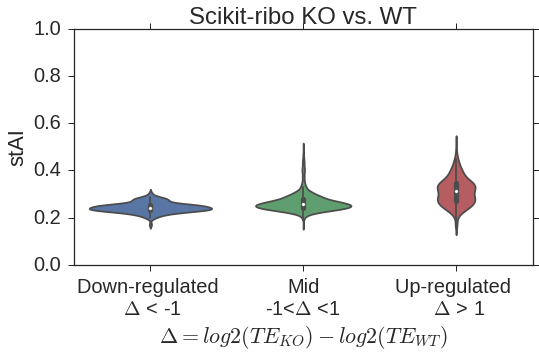

(53, 11) (335, 11)


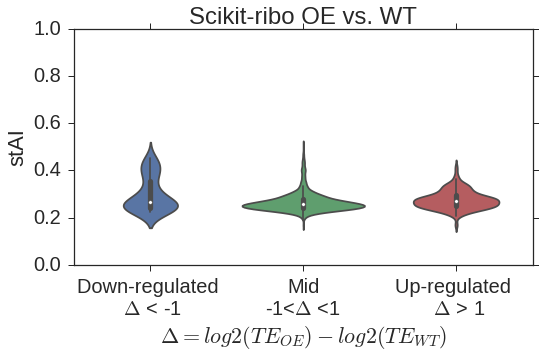

(220, 11) (269, 11)


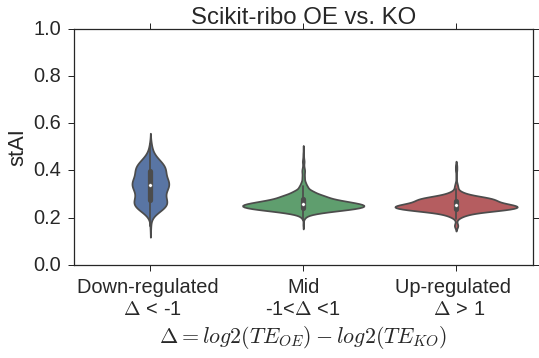

(544, 5) (377, 5)


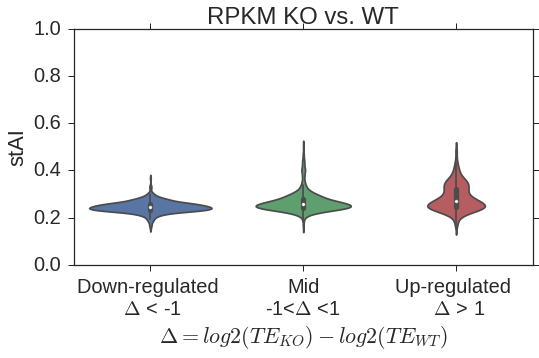

(91, 5) (1419, 5)


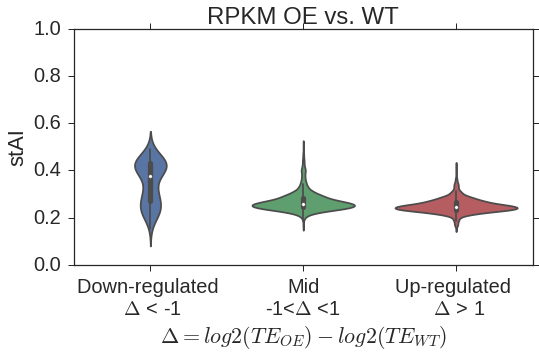

(246, 5) (2256, 5)


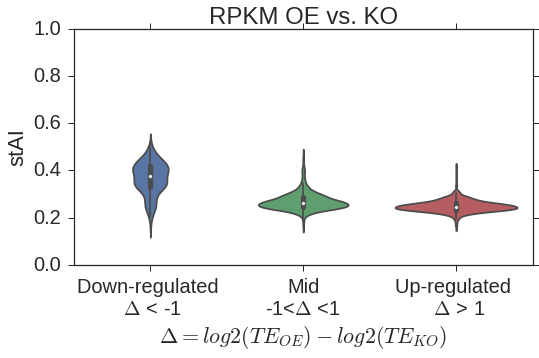

In [60]:
# stAI in three classes
for prefix in prefixes:
    for comparison in comparisons:
        l, r = comparison
        data_prefix = prefix + l + "_VS_" + r
        tmp = df_dic[data_prefix].copy()
        print(tmp[tmp["deltaTE"] < -deltaTE_cutoff].shape, tmp[tmp["deltaTE"] > deltaTE_cutoff].shape)
        tmp[tmp["deltaTE"] < -deltaTE_cutoff][["gene"]].to_csv(path_or_buf="../Data/Radhakrishnan/" + data_prefix + "_down.csv", 
                                                               sep='\t', header=True, index=False, quoting=csv.QUOTE_NONE) 
        tmp[tmp["deltaTE"] >  deltaTE_cutoff][["gene"]].to_csv(path_or_buf="../Data/Radhakrishnan/" + data_prefix + "_up.csv", 
                                                               sep='\t', header=True, index=False, quoting=csv.QUOTE_NONE) 
        tmp["isDownRegulated"] = np.where(tmp["deltaTE"] < -deltaTE_cutoff, -1, 0) 
        tmp["isUpRegulated"] = np.where(tmp["deltaTE"] > deltaTE_cutoff, 1, 0) 
        tmp["class"] = tmp["isDownRegulated"] + tmp["isUpRegulated"]
        plt.clf()
        vio1=sns.violinplot(x="class", y="stAI", data=tmp)
        plt.ylabel('stAI') 
        vio1.set_xticklabels(["Down-regulated \n $\Delta$ < -" + str(deltaTE_cutoff), 
                              "Mid\n" + "-1<$\Delta$ <1" ,
                              "Up-regulated \n $\Delta$ > " + str(deltaTE_cutoff)])
        plt.ylim(0, 1)
        
        tool = "Scikit-ribo " if prefix == "skr_" else "RPKM "
        plt.title(tool + l + " vs. " + r) 
        plt.xlabel("$\Delta = log2(TE_{" + l + "}) - log2(TE_{" + r + "})$")
        plt.tight_layout(); plt.gcf()
        plt.savefig("../Figures/Radhakrishnan/" + data_prefix + "_stAI.pdf")
        plt.show()

### 2) Compare RPKM estimates

### OE vs WT
#### down-regulated

|GO Term|	p-Value |	Matches
| :- |-------------: | :-:
|cytosolic ribosome [GO:0022626] |	0.001628 |	10 
|cytosolic part [GO:0044445] |	0.005072 |	11 

#### up-regulated

|GO Term|	p-Value |	Matches
| :- |-------------: | :-:
|purine nucleoside triphosphate metabolic process [GO:0009144]	|3.676616e-23	|42
|purine ribonucleoside triphosphate metabolic process [GO:0009205]	|1.981089e-22|	41
|ATP metabolic process [GO:0046034]	|2.694787e-22|	40
|nucleoside triphosphate metabolic process [GO:0009141]	|3.331368e-22	|43
|ribonucleoside triphosphate metabolic process [GO:0009199] |	1.147398e-21	|41
|purine nucleoside monophosphate metabolic process [GO:0009126]	|5.683788e-19	|41

### KO VS WT
#### Down-regulated: No GO enrichment 
#### Up-regulated
|GO Term|	p-Value |	Matches
| :- |-------------: | :-:
|	purine nucleoside monophosphate metabolic process [GO:0009126]	|1.465617e-11	|31
|	purine ribonucleoside monophosphate metabolic process [GO:0009167]	|1.465617e-11|	31
|	purine ribonucleoside triphosphate metabolic process [GO:0009205]	|4.539720e-11	|28
|	purine nucleoside triphosphate metabolic process [GO:0009144]	|7.742109e-11	|28
|	ribonucleoside triphosphate metabolic process [GO:0009199]	|1.302754e-10	|28

### DQAD VS WT
#### Down-regulated: 
|GO Term|	p-Value |	Matches
| :- |-------------: | :-:
|	mRNA processing [GO:0006397]	|0.008208	|14
|	spliceosomal complex [GO:0005681]	|0.001233|	10
#### Up-regulated : No GO enrichment

### 4) OE VS KO

### OE VS KO
#### Down-regulated: 
|GO Term| p-Value | Matches
| :- |-------------: | :-:
|	cytoplasmic translation [GO:0002181]|	3.286857e-44|	64
|	translation [GO:0006412]|	7.604883e-17|	80
|	ribosome biogenesis [GO:0042254]|	9.762228e-17|	62
|	peptide biosynthetic process [GO:0043043]|	1.065426e-16|	80
|	ribonucleoprotein complex biogenesis [GO:0022613]|	1.716538e-16|	68
|	amide biosynthetic process [GO:0043604]|	3.384313e-16|	82
|	peptide metabolic process [GO:0006518]|	2.521790e-15|	80
|	organonitrogen compound metabolic process [GO:1901564]|	4.557351e-15|	109
|	cellular amide metabolic process [GO:0043603]|	1.089971e-14|	83
|	translational elongation [GO:0006414]|	1.653967e-14|	67
|	ribosome assembly [GO:0042255]|	7.259525e-13|	24

#### Up-regulated : 
|GO Term| p-Value | Matches
| :- |-------------: | :-:	
|mitochondrial part [GO:0044429]	|4.173601e-4|	51
|	inner mitochondrial membrane protein complex [GO:0098800] |	0.001243|	15
|	mitochondrial protein complex [GO:0098798] |	0.002072|	17
|	membrane-bounded organelle [GO:0043227] |	0.007564|	210
|	cell part [GO:0044464] |	0.024648|	249
|	cell [GO:0005623] |	0.025540|	249
|	mitochondrial respiratory chain [GO:0005746] |	0.027369|	8
|	respiratory chain complex [GO:0098803] |	0.027369|	8
|	intracellular membrane-bounded organelle [GO:0043231] |	0.030143|	206

## 4. Compare codon elongation rates between strains

In [61]:
strains = ["WT", "KO", "OE"]
for strain in strains:
    tmp = df_dic["codon_" + strain].copy()
    df_dic["codon_" + strain]["dwell_time_" + strain] = (tmp["codon_dwell_time_rep1"] + 
                                                         tmp["codon_dwell_time_rep2"]) / 2
    print("s.d.: ",  strain, np.std(df_dic["codon_" + strain]["dwell_time_" + strain]))

s.d.:  WT 0.364064203447
s.d.:  KO 0.453428032829
s.d.:  OE 0.272951642927


In [62]:
codon_all_strains = pd.merge(df_dic["codon_WT"], df_dic["codon_KO"], on="codon")
codon_all_strains = pd.merge(codon_all_strains, df_dic["codon_OE"], on="codon")

/sonas-hs/lyon/hpc/home/hfang/.local/lib/python3.4/site-packages/statsmodels-0.6.1-py3.4-linux-x86_64.egg/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


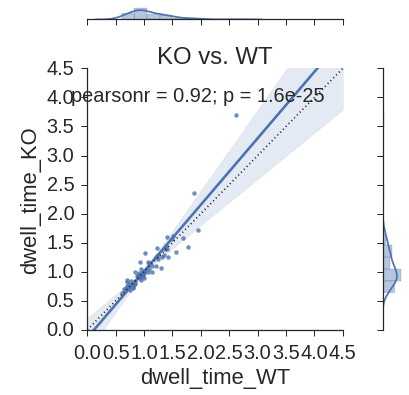

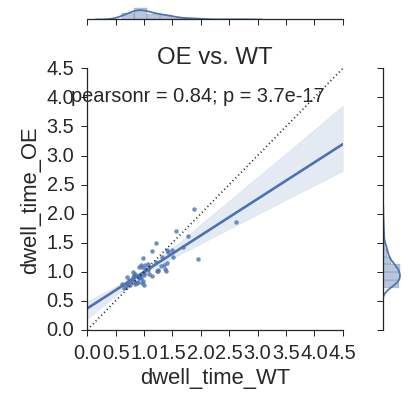

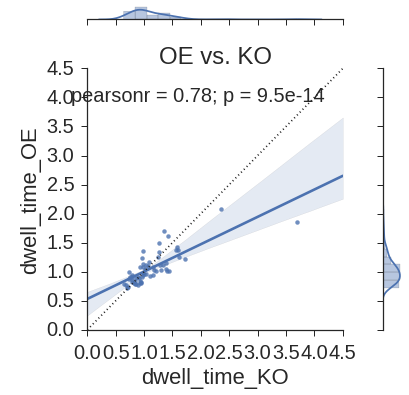

In [63]:
comparisons = [("KO", "WT"), ("OE", "WT"), ("OE", "KO")] 
for comparison in comparisons:
    l, r = comparison
    plt.clf()
    c1 = sns.jointplot(x="dwell_time_" + r, y="dwell_time_" + l, 
                       kind="reg", data=codon_all_strains, 
                       xlim=[0,4.5], ylim=[0,4.5])
    x0, x1 = c1.ax_joint.get_xlim()
    y0, y1 = c1.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    c1.ax_joint.plot(lims, lims, ':k')
    plt.title(l + " vs. " + r) 
    plt.tight_layout()
    plt.gcf()
    plt.savefig("../Figures/Radhakrishnan/"+ l + "_VS_" + r + "_codon_corr.pdf")
    plt.show()

#### Different from paper

In [64]:
codon_all_strains["delta_DT_OE_VS_WT"] = codon_all_strains["dwell_time_OE"] / codon_all_strains["dwell_time_WT"]
codon_all_strains["delta_DT_OE_VS_KO"] = codon_all_strains["dwell_time_OE"] / codon_all_strains["dwell_time_KO"]

(array([ 1.,  0.,  1.,  1.,  2.,  7.,  4.,  1.,  4.,  5.,  7.,  5.,  1.,
         4.,  6.,  2.,  5.,  0.,  3.,  2.]),
 array([ 0.62420203,  0.6580812 ,  0.69196037,  0.72583954,  0.75971871,
         0.79359788,  0.82747705,  0.86135622,  0.89523539,  0.92911456,
         0.96299373,  0.9968729 ,  1.03075206,  1.06463123,  1.0985104 ,
         1.13238957,  1.16626874,  1.20014791,  1.23402708,  1.26790625,
         1.30178542]),
 <a list of 20 Patch objects>)

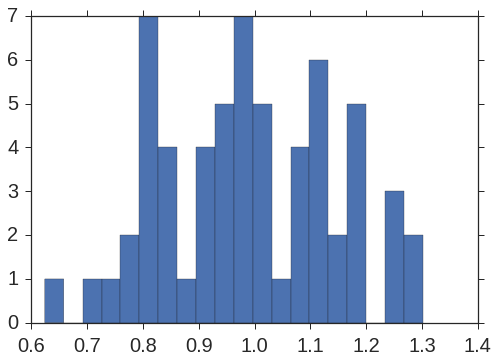

In [65]:
plt.hist(codon_all_strains["delta_DT_OE_VS_WT"], bins=20)

In [66]:
codon_all_strains = pd.merge(codon_all_strains, df_dic[codon_stAI], on="codon")
codon_all_strains['dwell_time_WT_rank'] = codon_all_strains['dwell_time_WT'].rank(ascending=1)

In [67]:
codon_all_strains[codon_all_strains["delta_DT_OE_VS_WT"] < 0.8].sort_values("delta_DT_OE_VS_WT")

,codon,codon_dwell_time_rep1_x,codon_dwell_time_rep2_x,dwell_time_WT,codon_dwell_time_rep1_y,codon_dwell_time_rep2_y,dwell_time_KO,codon_dwell_time_rep1,codon_dwell_time_rep2,dwell_time_OE,delta_DT_OE_VS_WT,delta_DT_OE_VS_KO,stAI,dwell_time_WT_rank
21,CCC,2.0917,1.8245,1.95810,1.7545,1.6922,1.72335,1.1827,1.2618,1.22225,0.624202,0.709229,0.219,60.0
22,CCG,2.9446,2.2907,2.61765,4.0101,3.3741,3.69210,1.8879,1.8222,1.85505,0.708670,0.502438,0.393,61.0
20,CCA,1.4278,1.3273,1.37755,1.4522,1.4339,1.44305,0.9871,1.0347,1.01090,0.733839,0.700530,0.518,50.0
23,CCT,1.4351,1.3085,1.37180,1.4095,1.3593,1.38440,1.0318,1.0589,1.04535,0.762028,0.755092,0.104,49.0
39,GCT,1.0000,0.9914,0.99570,0.8729,0.9108,0.89185,0.7607,0.7706,0.76565,0.768957,0.858496,0.569,31.0


In [68]:
codon_all_strains[codon_all_strains["delta_DT_OE_VS_WT"] > 1.2].sort_values("delta_DT_OE_VS_WT", ascending=False)

,codon,codon_dwell_time_rep1_x,codon_dwell_time_rep2_x,dwell_time_WT,codon_dwell_time_rep1_y,codon_dwell_time_rep2_y,dwell_time_KO,codon_dwell_time_rep1,codon_dwell_time_rep2,dwell_time_OE,delta_DT_OE_VS_WT,delta_DT_OE_VS_KO,stAI,dwell_time_WT_rank
19,CAT,0.5709,0.6389,0.6049,0.6541,0.6248,0.63945,0.8077,0.7672,0.78745,1.301785,1.231449,0.048,1.0
57,TTA,0.6449,0.7471,0.6960,0.7337,0.7792,0.75645,0.9081,0.8940,0.90105,1.294612,1.191156,0.362,5.0
31,CTT,0.9515,1.0225,0.9870,0.9286,0.9807,0.95465,1.2859,1.1718,1.22885,1.245035,1.287226,0.007,29.0
56,TGT,0.7988,0.8086,0.8037,0.7311,0.7253,0.72820,1.0293,0.9629,0.99610,1.239393,1.367893,0.028,11.0
29,CTC,1.1620,1.2444,1.2032,1.2312,1.2890,1.26010,1.5491,1.4305,1.48980,1.238198,1.182287,0.052,42.0


In [69]:
codon_all_strains[codon_all_strains["codon"] == "AGG"]

,codon,codon_dwell_time_rep1_x,codon_dwell_time_rep2_x,dwell_time_WT,codon_dwell_time_rep1_y,codon_dwell_time_rep2_y,dwell_time_KO,codon_dwell_time_rep1,codon_dwell_time_rep2,dwell_time_OE,delta_DT_OE_VS_WT,delta_DT_OE_VS_KO,stAI,dwell_time_WT_rank
10,AGG,1.4876,1.3264,1.407,1.6386,1.5428,1.5907,1.4114,1.3282,1.3698,0.973561,0.86113,0.485,52.0
